### Collaborative Learning Network

In [1]:
import pandas as pd
import networkx as nx

#Data input: Exercise #1, #2, #3, #4
df = pd.read_excel('CE_4220.xlsx','Exercise1')

#Collaborative learning network
DG = nx.DiGraph()
DG.add_nodes_from(df.iloc[:,0])
for j in range(1, df.shape[1]):
    for index,value in enumerate(df.iloc[:,j]):
        if not pd.isna(value):
            DG.add_edge(df.iloc[:,0][index], j, weight=value)

print(DG)
print(DG.edges.data())

DiGraph with 29 nodes and 37 edges
[(1, 4, {'weight': 3.0}), (1, 26, {'weight': 2.0}), (2, 7, {'weight': 2.0}), (2, 8, {'weight': 4.0}), (2, 27, {'weight': 2.0}), (3, 9, {'weight': 1.0}), (3, 18, {'weight': 1.0}), (4, 1, {'weight': 3.0}), (4, 26, {'weight': 3.0}), (5, 15, {'weight': 2.0}), (5, 16, {'weight': 2.0}), (5, 25, {'weight': 2.0}), (8, 2, {'weight': 3.0}), (9, 3, {'weight': 2.0}), (9, 18, {'weight': 3.0}), (11, 29, {'weight': 2.0}), (12, 14, {'weight': 2.0}), (12, 28, {'weight': 2.0}), (15, 5, {'weight': 3.0}), (15, 16, {'weight': 2.0}), (15, 25, {'weight': 2.0}), (17, 21, {'weight': 2.0}), (17, 24, {'weight': 3.0}), (18, 9, {'weight': 1.0}), (19, 20, {'weight': 1.0}), (20, 13, {'weight': 2.0}), (20, 19, {'weight': 2.0}), (22, 6, {'weight': 2.0}), (22, 10, {'weight': 2.0}), (23, 11, {'weight': 1.0}), (23, 29, {'weight': 1.0}), (24, 17, {'weight': 2.0}), (24, 21, {'weight': 2.0}), (26, 1, {'weight': 1.0}), (28, 12, {'weight': 1.0}), (29, 11, {'weight': 4.0}), (29, 23, {'weight'

### Centrality Measures

In [2]:
#Centrality measures
centrality = pd.DataFrame({'node': df.iloc[:,0].tolist(),
                           'in_degree': dict(DG.in_degree(weight='weight')).values(),
                           'out_degree': dict(DG.out_degree(weight='weight')).values(),
                           'betweenness': nx.betweenness_centrality(DG, weight='weight').values(),
                           'closeness': nx.closeness_centrality(DG).values()})

#Subgraph labeling
subgraph = list(nx.weakly_connected_components(DG))
for i in range(len(subgraph)):
    for node in subgraph[i]:
        centrality.loc[centrality[centrality['node'] == node].index.tolist()[0], 'label'] = i + 1

#Numerical centrality table
centrality.head()

,node,in_degree,out_degree,betweenness,closeness,label
0,1,4.0,5.0,0.001323,0.071429,1.0
1,2,3.0,8.0,0.002646,0.035714,2.0
2,3,2.0,2.0,0.000661,0.047619,3.0
3,4,3.0,6.0,0.000000,0.047619,1.0
4,5,3.0,6.0,0.000000,0.035714,4.0


In [3]:
#Group by subgraphs
group = centrality.groupby('label', as_index=False).mean()

#Centrality labeling criterion
def centrality_labeling(x, v):
    return 0 if x == 0 else 1 if x < v else 2

centrality_c = centrality[['node','in_degree','out_degree','betweenness','closeness']]

for col in centrality.iloc[:,1:5].columns:
    for row in range(centrality.shape[0]):
        v = group.loc[group[group['label'] == centrality.loc[row,'label']].index.tolist()[0],col]
        centrality_c.loc[row,col] = centrality_labeling(centrality.loc[row,col], v)

#Categorical centrality table
centrality_c.head()

,node,in_degree,out_degree,betweenness,closeness
0,1,2.0,2.0,2.0,2.0
1,2,2.0,2.0,2.0,1.0
2,3,1.0,1.0,2.0,1.0
3,4,1.0,2.0,0.0,1.0
4,5,1.0,2.0,0.0,1.0


### Roles Identification

In [4]:
#Roles: Leader, Animator, Active, Peripheral, Quiet, Missing

#Roles identification criterion
def role_identification(in_degree, out_degree, betweenness, closeness):
    if out_degree == 2:
        if betweenness == 2:
            if in_degree == 2 and closeness == 2:
                return 'Leader'
            else:
                return 'Animator'
        else:
            return 'Active'
    elif out_degree == 1:
        return 'Peripheral'
    else:
        if in_degree == 0 and closeness == 0:
            return 'Missing'
        else:
            return 'Quiet'

for row in range(centrality_c.shape[0]):
    parameters = tuple(centrality_c.loc[row,['in_degree','out_degree','betweenness','closeness']])
    centrality_c.loc[row,'role'] = role_identification(*parameters)

#Data output
#pd.concat([centrality,centrality_c['role']], axis=1).to_csv('Network_information.csv', index=False)
pd.concat([centrality,centrality_c['role']], axis=1).head()

,node,in_degree,out_degree,betweenness,closeness,label,role
0,1,4.0,5.0,0.001323,0.071429,1.0,Leader
1,2,3.0,8.0,0.002646,0.035714,2.0,Animator
2,3,2.0,2.0,0.000661,0.047619,3.0,Peripheral
3,4,3.0,6.0,0.000000,0.047619,1.0,Active
4,5,3.0,6.0,0.000000,0.035714,4.0,Active


### Network Visualization

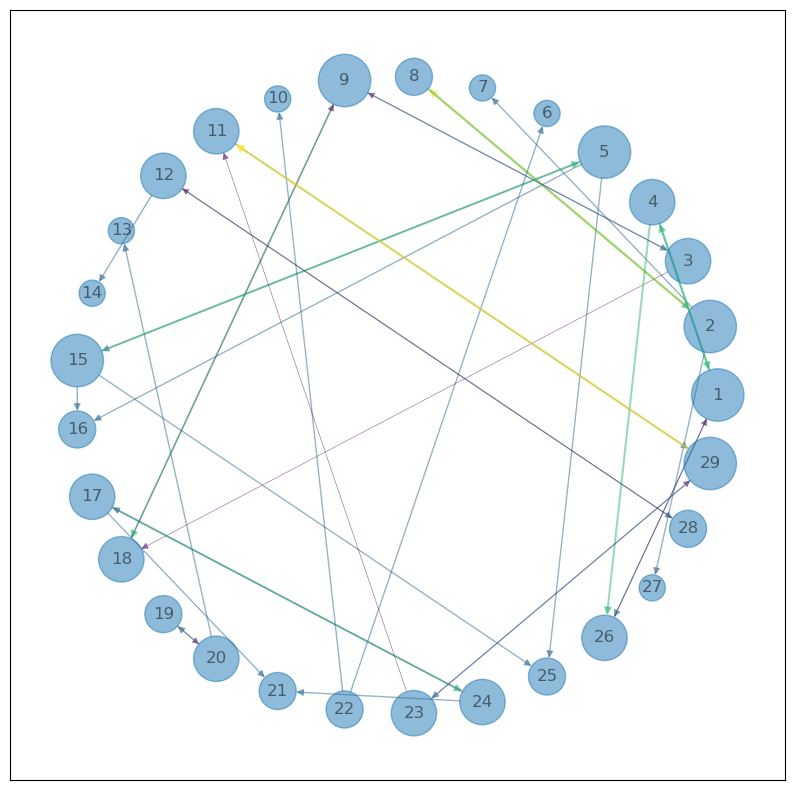

In [5]:
import matplotlib.pyplot as plt

#Degree centrality
degree = nx.degree_centrality(DG)

#Visualization
pos = nx.circular_layout(DG)
node_size =  [10000*i for i in degree.values()]
edge_weight = nx.get_edge_attributes(DG, 'weight')
edge_width = [0.5*i for i in edge_weight.values()]
edge_color = [i for i in edge_weight.values()]

plt.figure(figsize = (10,10))
nx.draw_networkx(DG, pos, with_labels=True, node_size=node_size, width=edge_width, edge_color=edge_color, alpha=0.5)

plt.show()